### 참고

- 넷플릭스
    - 슬로건 : 모든 것이 추천이다
    - https://medium.com/netflixtechblog/55838468f429
    - 넷플릿스의 추천 알고리즘 구현에 대한 기술 블로그 공개

# 1. 연구 목표

- 사용자 평점 데이터를 기반으로 사용자를 특정을 예측하여 추천 시스템을 구축한다
- 실제, OTT, 쇼핑몰에서 회원가입시 추천 알고리즘으로 사용된다
- 회귀 처리, 회귀 평가, 추천시스템에 대한 이해
- FastFM (third party 알고리즘 사용->인수분해머신 기능 지원)
    - 윈도우에서 컴파일후 설치가 불가하므로, 리눅스에 설치하여 개발을 진행

# 2. 데이터 수집/확보

- ml-100k.zip 파일 제공
    - 미국에 있는 movelens라는 사이트에서 제공
- 영화 정보 데이터
    - 고객 정보 : u.user
    - 영화 정보
    - 평점 점보

In [2]:
import pandas as pd

In [3]:
# u.user 라는 데이터에 컬럼이 없다보니, 첫번재 데이터가 컬럼이 되었다 
# 이를 예방하기 위해서는, 컬럼을 지정한다 
cols  = ['uid','age','m','job','zip_code']
users = pd.read_csv('./table/ml-100k/u.user', sep='|', names=cols)
users.head(1)

,uid,age,m,job,zip_code
0,1,24,M,technician,85711


In [4]:
users.tail(1)

,uid,age,m,job,zip_code
942,943,22,M,student,77841


In [5]:
# 고객 943명의 데이터
users.shape

(943, 5)

In [6]:
# 영화 정보 로드
m_cols  = ['mid','title','release_date','video_release_date','imdb_url']
# 영어권이면 utf-8에서 에러나면 latin1으로 사용
# 원본 데이터의 컬럼이 많은데 부분만 쓰고 싶다면, usecols를 적용
movies = pd.read_csv('./table/ml-100k/u.item', sep='|', 
                     encoding='latin1', names=m_cols, usecols=range(5))
movies.head(2)

,mid,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...


In [7]:
movies.tail(2)

,mid,title,release_date,video_release_date,imdb_url
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...


In [8]:
movies.shape

(1682, 5)

In [9]:
# 평점 정보 : u.data
r_cols  = ['uid','mid','rating','unix_timestamp']
ratings = pd.read_csv('./table/ml-100k/u.data', sep='\t', names=r_cols)
ratings.head(1)

,uid,mid,rating,unix_timestamp
0,196,242,3,881250949


In [10]:
ratings.tail(1)

,uid,mid,rating,unix_timestamp
99999,12,203,3,879959583


In [11]:
ratings.shape

(100000, 4)

In [12]:
ratings.unix_timestamp, ratings[ 'unix_timestamp' ]

(0        881250949
 1        891717742
 2        878887116
 3        880606923
 4        886397596
            ...    
 99995    880175444
 99996    879795543
 99997    874795795
 99998    882399156
 99999    879959583
 Name: unix_timestamp, Length: 100000, dtype: int64, 0        881250949
 1        891717742
 2        878887116
 3        880606923
 4        886397596
            ...    
 99995    880175444
 99996    879795543
 99997    874795795
 99998    882399156
 99999    879959583
 Name: unix_timestamp, Length: 100000, dtype: int64)

In [13]:
# unix_timestamp는 1970년 1월 1일 00시 00분 00초 부터 현재까지 경과된 시간 + 09:00
# 그래서, 현재시간, 특정시간을 특정하기가 어렵다 -> 해석이 어렵다 -> 시간형식 변경
ratings['date'] = pd.to_datetime( ratings.unix_timestamp, unit='s' )

In [14]:
ratings.head(2)

,uid,mid,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22


In [15]:
# 3. 데이터 준비/품질향상/전처리
# 4. 데이터 분석/통계적,시각적,...

In [16]:
# 평점과 영화 데이터 합치기
# 합친결과=> (10000, 9)
# merge()를 수행할때 중복되는 컬럼을 생략하면 알아서 찾아서 수행된다.
# 단, 컬럼이 2개이상이면 검토가 필요
movies_ratings = pd.merge( movies, ratings, on='mid')
movies_ratings.shape

(100000, 9)

In [17]:
movies_ratings.head(2)

,mid,title,release_date,video_release_date,imdb_url,uid,rating,unix_timestamp,date
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,287,5,875334088,1997-09-27 04:21:28


In [18]:
# movies_ratings, users => 합치기
movie_lens = pd.merge( movies_ratings, users)
movie_lens.shape

(100000, 13)

In [19]:
movie_lens.head(2)

,mid,title,release_date,video_release_date,imdb_url,uid,rating,unix_timestamp,date,age,m,job,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076


- 데이터를 모두 병합하였다, 평점이나 회원을 중심으로 중복적인 데이터가 많다
- 데이터가 적으면 크게 문제 없으나, 크면 메모리를 많이 사용할수도 있다 (검토)

In [20]:
# 평가를 가장 많이 받은 영화 상위 10개 출력하시오
# mid나 title 둘다 사용이 가능하나, 결과를 이해하기 위해서 title을 사용
movie_lens.title.value_counts()[:10]

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

In [21]:
# 평점을 받은 횟수가 적은경우, 우연히 평점이 좋을수도 있다 
# 데이터를 조정할때, 특정 회수(임계치) 이상 평가한 작품만 고려하겠다
movie_lens.title.value_counts()[-10:]

Next Step, The (1995)                                 1
Pharaoh's Army (1995)                                 1
Death in the Garden (Mort en ce jardin, La) (1956)    1
Homage (1995)                                         1
Invitation, The (Zaproszenie) (1986)                  1
Century (1993)                                        1
JLG/JLG - autoportrait de décembre (1994)             1
Tigrero: A Film That Was Never Made (1994)            1
Big One, The (1997)                                   1
Raw Deal (1948)                                       1
Name: title, dtype: int64

- 제목기준으로 데이터를 분류
- 평가의 개수, 평균평점이 들어가있는 DF
- 인덱스:title, 컬럼:개수, 평균평점<=만드는 과정에서 컬럼의 레벨이 1이상이 되고 관계없음)

In [22]:
movie_lens.columns

Index(['mid', 'title', 'release_date', 'video_release_date', 'imdb_url', 'uid',
       'rating', 'unix_timestamp', 'date', 'age', 'm', 'job', 'zip_code'],
      dtype='object')

In [23]:
import numpy as np

In [24]:
# groupby(컬럼) : 해당 컬럼이 인덱스로 이동
# agg( {컬럼:[값처리함수,...]} ) : 컬럼에 처리함수개수대로 설정되서 값이 자동 처리
movie_state = movie_lens.groupby('title').agg( {'rating':[np.size, np.mean]} )
movie_state.head(2)

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000

In [25]:
# 이 케이스에서는 피벗의 표현이 좀더 복잡할수 있어서 배제
# movie_lens.pivot_table( index='title')

- 평점을 받은 개수가 1개인 경우, 소수의 평가를 받은 영화
- 평균의 수가 적으면 잡음의 개입이 여지가 많다 
- 100건 기준으로 100개 이상만 대상으로 처리 (임계값)

In [26]:
# 차후 변경함으로써 성능을 다르게 낼수 있다
limit_std_value = 100
condition       = movie_state['rating']['size'] >= limit_std_value
condition[:2]

title
'Til There Was You (1997)    False
1-900 (1994)                 False
Name: size, dtype: bool

In [27]:
# 블리언 인덱싱
movie_state[ condition ][:2]

rating          
                        size      mean
title                                 
101 Dalmatians (1996)    109  2.908257
12 Angry Men (1957)      125  4.344000

In [28]:
# 정렬 -> 평균 내림차순으로 정렬하여 상위 5개만 출력
# 컬럼레벨이 n차인 경우 정렬하는 방법
tmp = movie_state[ condition ].sort_values( by=[ ('rating', 'mean') ], 
                                            ascending=False )
tmp.head()

rating          
                                   size      mean
title                                            
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230

In [29]:
# 영화 1682개중에 임계값을 통과한 대상은 338개이다
# 이를 통해서 평점을 적게 받은 영화의 통계적인 추정도 가능하다
tmp.shape, movies.shape

((338, 2), (1682, 5))

In [30]:
# 간단한 시각화
# 영화별 평점 개수 : x축
# 평가 회수 : y축
from matplotlib import pyplot as plt

%matplotlib inline

'\nStar Wars (1977)                 583\n스타워즈 1977년 작품에 평가가 583회가 수행되었는데, 이중에는 \n이 영화만 평가한 유저도 다수 존재한다(현 데이터에서는 최저 평가 회수가 사용자당 20)\n'

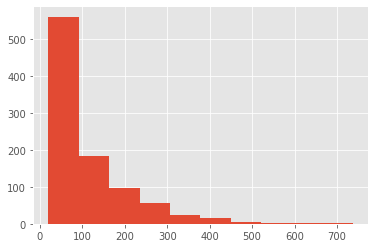

In [31]:
# 히스토그램
plt.style.use('ggplot')
movie_lens.groupby('uid').size().sort_values( ascending=False ).hist()
# 사용자의 평가 횟수에 대한 성향
# 빈도가 점점 낮아진다 -> 길게 꼬리를 늘어뜨리는 모양 -> 롱테일분포
# "지프의 법칙"을 따른 굴곡 모양이다
# 영화의 평가가 많으면, 그 사용자들 중에는 1회성 평가 회수도 많다
'''
Star Wars (1977)                 583
스타워즈 1977년 작품에 평가가 583회가 수행되었는데, 이중에는 
이 영화만 평가한 유저도 다수 존재한다(현 데이터에서는 최저 평가 회수가 사용자당 20)
'''

In [32]:
# 사용자별 평가 회수, 평균
user_state = movie_lens.groupby('uid').agg( { 'rating':[np.size, np.mean]} )
user_state.head(2)

rating          
      size      mean
uid                 
1      272  3.610294
2       62  3.709677

In [33]:
user_state.shape

(943, 2)

In [34]:
user_state.describe()
# 최저값:1.49, 최대:4.87, 25~75% 지점 : 3점대로 몰렸잇다
# 평균 ; 3.58 => 어떤 영화든지 일반적으로 3점이상은 받는다
# 3점 이하는 영화 자체에 문제가 있어 보인다
# 최고, 최저는 편중되어 있다

rating            
             size        mean
count  943.000000  943.000000
mean   106.044539    3.588191
std    100.931743    0.445233
min     20.000000    1.491954
25%     33.000000    3.323054
50%     65.000000    3.620690
75%    148.000000    3.869565
max    737.000000    4.869565

### 5. 예측모델구축(머신러닝기반)

- 알고리즘 => 인수분해 머신기능을 제공하는 FastFM이라는 모듈 사용
- FastFM
    - C++로 만들어진 libFM이라는 알고리즘
    - libFM을 python으로 구성한것이 fastFM
    - 기능
        - 행렬 인수 분해라는 기능을 일반화하여서 제공 -> 차원축소기법
        - 범주형 변수를 파생변수로 변환하여 범주간의 상호 작용성을 계산
        - 특징 간 영향을 주고 받은 상호 작용 개념을 계산

- fastFM 제공 알고리즘
    - ALS : 교대 최소 제곱법
        - 장점: 예측시간빠름, SGD비해 하이퍼파라미터가 작다
        - 단점: 규제처리가 필요
    - SGD : 확률적 경사 하강법
        - 장점: 예측시간빠름, 빅데이터를 빠르게 처리학습할수 있다
        - 단점: 하이퍼파라미터가 많다, 규제처리가 필요
    - MCMC: 마르코프 연쇄 몬테카를로
        - 장점: 하이퍼파라미터가 작다, 자동규제
        - 단점: 학습시간이 느리다

In [35]:
# 아마존 EC2 서버에 접속하였다
# febric3를 이용하여 이하 과정을 자동화 할수 있다

# 리눅스상에서 루트 권한 획득
ubuntu:$ sudo su

# 리눅스의 현재 설치된 패키지등을 최신으로 업그레이드
root:$ apt-get update && apt-get -y upgrade
    
# 파이썬 확인
$ python -V
or 
$ python3 -V

# 패키지 설치 (파이썬이 설치 되어 있으면 파이썬 부분은 제외)
$ apt-get -y install python3-dev python3-pip git nano wget unzip libopenblas-dev
# 파이썬이 있으면 이하만 설치
$ apt-get -y install python3-pip git nano wget unzip libopenblas-dev

# fastFM 소스 다운로드
$ git clone --recursive https://github.com/ibayer/fastFM.git
$ cd fastFM  

# 컴파일을 수행하기 전에 python 모듈 설치
# 내용 확인
$ cat requirements.txt
$ pip3 install -r ./requirements.txt

# 컴파일 -> 마지막 부분에 error가 보여도 무시
$ PYTHON=python3 make

# fastFM 설치 
$ pip3 install .

# 확인
$ python3
>>> from fastFM import als
>>> exit()

# 개발에 필요한 패키지 설치
$ pip3 install pandas matplotlib jupyter

# (옵션) 삭제
$ rm -r -f dev

# root 계정 오프
$ exit

# 작업폴더 생성
ubuntu$ cd ..
$ mkdir dev && cd dev

# 주피터 가동
$ jupyter notebook --ip=0.0.0.0 --port=8888 --allow-root --no-browser
$ jupyter notebook --ip=0.0.0.0 --allow-root --no-browser

http://15.164.218.167:8888/?token=51bfb3e5df36cba99000fbc2a3d6e353f420e283792053d9
http://15.164.218.167:8888/?token=f2fd41ebd6fab0b20bdbd9e40266fdd91c87ba6cb6cdfd18

        




SyntaxError: invalid syntax (<ipython-input-35-3fb33c78d949>, line 5)

In [ ]:
# 백그라운드에서 주피터 가동
$ nohup jupyter-notebook --ip=0.0.0.0 --allow-root --no-browser --NotebookApp.token='' 1>/dev/null 2>&1 &

# 만약 토큰이 궁금하면
$ ubuntu@ip-172-31-43-149:~/dev$ jupyter-notebook list
Currently running servers:
http://0.0.0.0:8888/?token=5367a490fd597ea07a79a704c4392edd52de7d13d5e914e0 :: /home/ubuntu/dev

# 터미널 닫아도됨

# 향후 백그라운드에서 주피터 죽이기
$ ps -e
---
 7127 pts/0    00:00:00 jupyter-noteboo
---
# 프로세스 목록에서 jupyter-notebook를 찾아서
$ kill -9 7127 

### 가상 데이터를 이용하여 기능 확인

In [36]:
from sklearn.feature_extraction import DictVectorizer
import numpy as np

In [37]:
# DictVectorizer : 문자열만 백터화 처리
v = DictVectorizer()

In [38]:
# 더미 데이터
# 사용자 ID, 사용자가 평가한 영화 ID, 사용자의 나이
# 데이터가 작아서 편차가 크게 나온다 <= 더미 데이터 조정
train = [
    {'uid':'1', 'mid':'5',  'age':19},
    {'uid':'2', 'mid':'43', 'age':33},
    {'uid':'3', 'mid':'20', 'age':55},
    {'uid':'4', 'mid':'10', 'age':20},
]

In [39]:
X = v.fit_transform( train )
# 수치는 그대로 배치, 문자열이 들어간 데이터는 백터화로 처리
# 문자열은 범주형으로 보고 해당 케이스별로 배치하여 0 혹은 1로 표시
X.toarray()

array([[19.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [33.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [55.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [40]:
# ALS를 이용하여서 처리
from fastFM import als
from sklearn.model_selection import learning_curve

In [41]:
# 더미데이터중 20살짜리 유저 1번은 영화 5번에 평점 5.0을 부여했다
# 유저별로 부여한 평점
y = np.array( [5.0, 1.0, 2.0, 4.0] )

In [42]:
# ALS을 이용하여 fastFM의 회귀모델을 초기화후 학습을 진행
# 하이퍼파리미터는 임시값 부여
fm = als.FMRegression( n_iter=1000, init_stdev=0.1, 
                       rank=2, l2_reg_w=0.1, l2_reg_V=0.5 )
fm.fit( X, y )

FMRegression(init_stdev=0.1, l2_reg=0, l2_reg_V=0.5, l2_reg_w=0.1, n_iter=1000,
             random_state=123, rank=2)

In [43]:
# 예측
# 새로운 유저가 신규 가입을 하였다. uid가 5번이 되었다
# 나이가 24인 유저 5번 영화 10번에 대해 내릴 평점을 예측해라
# {'uid':'5', 'mid':'10', 'age':24},
fm.predict( v.transform( {'uid':'5', 'mid':'10', 'age':24} ) )

array([3.60775939])

- 제공되는 데이터는 ua.base, ua.test는 훈련용과 테스트용이 구분되어 있다
- 이를 읽어서 자료구조를 만드는 형태로 처리하는 함수 구현

In [44]:
def loadData( fileName, path='./table/ml-100k/' ):
    data = list() # 학습용 데이터 형태
    y    = list() # 답안(평점)
    # 데이터 추출및 구조 작업
    with open( path + fileName ) as f: # 파일 오픈
        # 한줄씩 읽어서 처리
        for line in f:
            # 데이터 한줄을 구분해서 추출
            uid, mid, rating, ts = line.split('\t')            
            # 유저아이디와 영화아이디 추가
            data.append( {'uid':str(uid), 'mid':str(mid) } )
            # 점수 추가
            y.append( float( rating ) )
    
    return data, np.array(y)

# 훈련용 데이터 획득
dev_data, y_dev = loadData( 'ua.base' )

In [45]:
len(dev_data), y_dev.shape, y_dev[:4]

(90570, (90570,), array([5., 3., 4., 3.]))

In [46]:
# 테스트용 데이터 획득
test_data, y_test = loadData( 'ua.test' )
len(test_data), y_test.shape, y_test[:4]

(9430, (9430,), array([4., 4., 4., 3.]))

In [47]:
# 해당 함수 확장 loadDataEx
# 평가에 참가한 유저들의 ID만 모은 데이터셋, 영화의 ID만 모은 데이터셋
def loadDataEx( fileName, path='./table/ml-100k/' ):
    data = list()
    y    = list()
    # 중복데이터를 제거하는 자료구조 생성
    users= set()
    movies=set()
    with open( path + fileName ) as f:
        for line in f:            
            uid, mid, rating, ts = line.split('\t')                        
            data.append( {'uid':str(uid), 'mid':str(mid) } )            
            y.append( float( rating ) )    
            # 평가 데이터에서 uid, mid를 추가
            users.add( uid )
            movies.add( mid )
    return data, np.array(y), users, movies

In [48]:
# 훈련용 데이터 획득
dev_data, y_dev, dev_users, dev_movies     = loadDataEx( 'ua.base' )
# 테스트용 데이터 획득
test_data, y_test, test_users, test_movies = loadDataEx( 'ua.test' )

In [49]:
len(test_data), len(y_test)

(9430, 9430)

In [50]:
# 훈련용및 테스트용에 참가한 유저수는 동수
# 영화수는 훈련용이 테스용보다 많다
len(dev_users), len(dev_movies), len(test_users), len(test_movies)

(943, 1680, 943, 1129)

- 데이터의 백터화 처리
- 사전에 데이터들을 수치라도 다 문자로 처리했다.
- 평점만 빼고, uid, mid값은 현재 문자열이다

In [51]:
# 확인
dev_data[:1]

[{'uid': '1', 'mid': '1'}]

In [52]:
v = DictVectorizer()

In [53]:
# 훈련용 데이터의 백터화
X_dev = v.fit_transform( dev_data )
X_dev.shape, type(X_dev)

((90570, 2623), scipy.sparse.csr.csr_matrix)

In [54]:
# 테스트 데이터의 백터화
X_test = v.transform( test_data )
X_test.shape

(9430, 2623)

In [55]:
# 표준편차 확인 -> 회귀에서 평가지수 => 평균제곱근오차를 계산할대 평가 잣대
np.std(y_dev), np.std(y_test)

(1.1260664426539722, 1.120180145761465)

In [56]:
from sklearn.model_selection import train_test_split

# 9:1 비율(임의 설정)
# random_state => 항상 동일하게 데이터가 섞이게 하기 위해서
X_train, X_dev_test, y_train, y_dev_test = train_test_split( X_dev, y_dev, 
                                                test_size=0.1, random_state=42 )

In [57]:
X_dev_test.toarray()[:1]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [58]:
X_train.shape, X_dev_test.shape

((81513, 2623), (9057, 2623))

- 데이터는 모두 준비되었다
- 회귀 모델에 학습및 예측을 수행하기위해 데이터의 형태를 알고리즘에 맞춰서 구성하였다

- 알고리즘 선택
    - mcmc
        - 학습및 예측 수행
        - 시각화 를 통해서 수렴해하는 과정 확인        
        - 테스트데이터를 이용한 성능 측정
            - 평균제곱근오차 및 손실함수를 이용하여 평가
        - 하이퍼파리미터 활용(고정)하여 평점의 정규화 처리, 성능 평가
        - 기타 정보 추가

In [59]:
# 평균제곱근오차 함수
from sklearn.metrics import mean_squared_error
from fastFM import mcmc

In [60]:
# 0. 실험 수치 설정
# mcmc의 하이퍼파라미터 
rank = 4
seed = 123
# 실험 임계값 변수 지정
n_iter = 300  # 반복 회수로 사용 (사용할때 확인)
step_size =1  # 훈련시 사용되는 값  (사용할때 확인)

In [61]:
# 1. 알고리즘 생성
# n_iter : 샘플수 (als에서는 학습 세트의 반복수, sgd에서는 단계)
# rank   : 인수분해의 순위
# random_state : 난수 고정(항상 동일한 결과치를 얻기 위해 사용)
fm = mcmc.FMRegression( n_iter=0, rank=rank, random_state=seed  )

In [62]:
# 2. 데이터 준비 (이미 위에서 구현)

In [63]:
# 3. 훈련 및 예측
fm.fit_predict(X_train, y_train, X_dev_test )

array([0., 0., 0., ..., 0., 0., 0.])

In [64]:
# 4. 손실함수를 구해서 어떤 값으로 수렴하는지를 확인
# 손실함수는 정답에 가까운 오류를 수치로 표현
# 오답에 가까울수록 값이 크다. 정답에 가까울수록 값이 작아진다
# 회귀모델에서 성능평가를 처리하는 지표: (평균제곱근오차를 통한 손실함수, 결정계수)
# 구하는 방법은 평균제곱근오차함수값을 제곱근 처리하면 나온다
# 평균제곱근오차함수의 인자값 (예측값, 예측에 사용한 데이터의 답)

In [65]:
# fm.hyper_param_을 담기 위해서 자료 구조를 준비
# 0 행렬
# 배열의 원소들은 타입이 모두 동일하다? OK, 
# 데이터 프레임의 원소들은 컬럼끼리만 동일하고, 컬럼대 컬럼으로 보면 다를수 있다
hyper_param = np.zeros( (n_iter-1 , rank*2 + 3), dtype=np.float64  )
hyper_param.shape

(299, 11)

In [66]:
# 구현환경은 n_iter만큼 반복하면서 수행을 하겟다
rmse_test = list()
for nr, i in enumerate(range(1, n_iter)): # 0:1, 1:2, ... ~ 298:299
    # 기준값 확인
    #print( nr, i)
    #break
    # 난수 변경 (학습및 예측 수행시 훈련/검증 폴드의 성분이 바뀐다)
    fm.random_state = i * seed # 1*123, 2*123 , .. 299*123
    # 학습 및 예측
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter=step_size )
    # 손실함수 값 획득
    loss_v = np.sqrt( mean_squared_error( y_pred, y_dev_test ) )
    # 손실함수 값을 모은다
    rmse_test.append( loss_v )
    # fm.hyper_param_ <= 배열, 11개의 성분을 가진다
    print(fm.hyper_param_, type(fm.hyper_param_))
    # hyper_param_을 담기
    # hyper_param는 300x11, hyper_param_은 11이다
    hyper_param[ nr, :] = fm.hyper_param_
    #break
hyper_param

[ 7.29936807e-02  1.01534507e+02  1.09545845e+02  1.00682624e+02
  9.07375308e+01  1.01817181e+02  1.43406954e-03 -1.17820912e-03
 -2.64130136e-04 -1.52355401e-03 -1.94369678e-03] <class 'numpy.ndarray'>
[ 8.36490856e-01  1.00123392e+02  1.05959358e+02  9.41424772e+01
  8.48872557e+01  9.63430325e+01 -1.97714841e-03 -1.57690950e-03
  6.35869726e-04 -3.12144587e-03 -2.98777035e-03] <class 'numpy.ndarray'>
[ 1.02700665e+00  3.23757929e+01  1.01870475e+02  9.20991603e+01
  8.16298813e+01  9.22876603e+01 -7.80849132e-03 -6.54788806e-03
  1.30186941e-03 -1.33292961e-03 -3.37801855e-03] <class 'numpy.ndarray'>
[ 1.11296461e+00  1.24257802e+01  1.00969880e+02  8.78492782e+01
  8.14037474e+01  8.35890933e+01 -3.60037498e-02 -4.29896035e-03
  5.23633472e-03  2.54055699e-03 -3.26100245e-03] <class 'numpy.ndarray'>
[ 1.15833652e+00  6.99396391e+00  9.90697250e+01  8.56177836e+01
  8.08977017e+01  7.68142612e+01 -5.06494647e-02  9.64403894e-04
  7.33988909e-03  6.68585270e-04  6.23401524e-04] <cla

array([[ 7.29936807e-02,  1.01534507e+02,  1.09545845e+02, ...,
        -2.64130136e-04, -1.52355401e-03, -1.94369678e-03],
       [ 8.36490856e-01,  1.00123392e+02,  1.05959358e+02, ...,
         6.35869726e-04, -3.12144587e-03, -2.98777035e-03],
       [ 1.02700665e+00,  3.23757929e+01,  1.01870475e+02, ...,
         1.30186941e-03, -1.33292961e-03, -3.37801855e-03],
       ...,
       [ 1.41530233e+00,  4.94956660e+00,  4.84472474e+00, ...,
        -1.59330595e-01, -2.75449109e-01,  1.48574867e-02],
       [ 1.40748074e+00,  5.36560318e+00,  5.02194975e+00, ...,
        -1.80935167e-01, -2.61153633e-01,  2.88644431e-03],
       [ 1.41138484e+00,  5.22930424e+00,  5.41863118e+00, ...,
        -1.47430605e-01, -2.64029678e-01,  1.06188403e-03]])

In [67]:
# 손실함수가 모여있는 자료구조
print( len(rmse_test) )
# fm.hyper_param_ 이 모여있는 자료구조
print( hyper_param.shape )

299
(299, 11)


In [68]:
# 시각화를 통해 값의 수렴의 추이를 살펴본다
from matplotlib import pyplot as plt

In [69]:
x = np.arange( 1, n_iter )
x.shape, x[:1], x[-1:]

((299,), array([1]), array([299]))

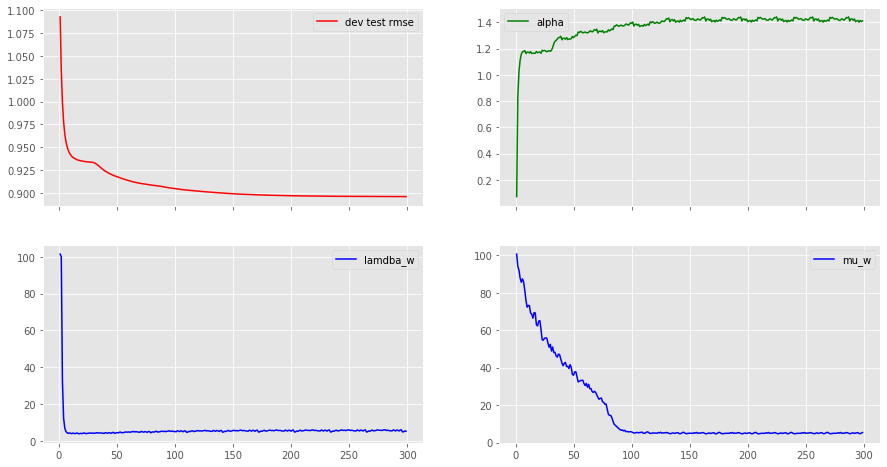

In [70]:
# 화면을 2x2 격자 모양으로 차트를 배치
fig, axes =  plt.subplots( nrows=2, ncols=2, sharex=True, figsize=(15,8) )

# x축은 1~299, 학습 수행횟수
axes[0, 0].plot( x, rmse_test, label='dev test rmse', color='r' )
axes[0, 0].legend()

axes[0, 1].plot( x, hyper_param[:, 0], label='alpha', color='g' )
axes[0, 1].legend()

axes[1, 0].plot( x, hyper_param[:, 1], label='lamdba_w', color='b' )
axes[1, 0].legend()

axes[1, 1].plot( x, hyper_param[:, 3], label='mu_w', color='b' )
axes[1, 1].legend()

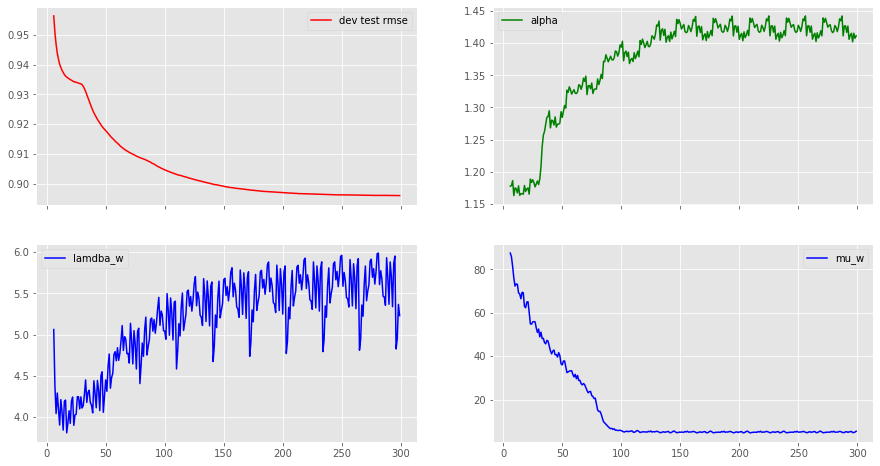

In [71]:
# 초기는 성능이 않나오는 지점이라서, 그래프가 길게 보이고, 세부 변화가 보이지 않는다
# 굳이 의미 없는 초기 수행 횟수는 제거하여서 차트를 좀더 상세하게 표현하겟다
# 상위 5개 데이터는 누락해서 처리 (lamdba_w이 값이 10 정도에서 수렴하는 것으로 보인다)
fig, axes =  plt.subplots( nrows=2, ncols=2, sharex=True, figsize=(15,8) )

# x축은 1~299, 학습 수행횟수
skip_idx = 5
axes[0, 0].plot( x[skip_idx:], rmse_test[skip_idx:], label='dev test rmse', color='r' )
axes[0, 0].legend()

axes[0, 1].plot( x[skip_idx:], hyper_param[skip_idx:, 0], label='alpha', color='g' )
axes[0, 1].legend()

axes[1, 0].plot( x[skip_idx:], hyper_param[skip_idx:, 1], label='lamdba_w', color='b' )
axes[1, 0].legend()

axes[1, 1].plot( x[skip_idx:], hyper_param[skip_idx:, 3], label='mu_w', color='b' )
axes[1, 1].legend()

In [72]:
# 손실함수의 최소값 
# 예측을 수행한후 획득한 값-> 최초 기준값으로보고, 이 수치보다 낮추면 성능을 향상
np.min(rmse_test)

0.8959692745565979

- 반복횟수가 100~150번 사이로 진입을 하면 rmse값은 안정화 되간다(수렴한다)
- 하이퍼파라미터들은 100, 150회를 넘으면서 안정화되가고 있다
- 검증 데이터, 테스트 데이터등 표준편차가 회귀 문제의 손실함수값의 평가를 담당하는 잣대
- 경향
    - 평균제곱근 오차값의 제곱근(손실함수)는 표준 편차에 가까워질려는 경향이 있다
    - 성능 향상은 반드시 값을 줄이는 방향이 아닌, 표준편차에 가까워지게 하는 방향으로 전개를 하면 된다

In [73]:
# 검증 데이터의 표준편차
np.std( y_dev_test )

1.1189348256323237

In [74]:
n_iter    = 100
seed      = 333
rmse_test = list()
# 랭크값 나열 
ranks     = [4, 8, 16, 32, 64]

for rank in ranks:
    # 다른 하이퍼파라미터는 모두 고정하고, rank만 바꿔가면서 rmse의 미치는 영향 확인
    fm = mcmc.FMRegression( n_iter=n_iter, rank=rank, random_state=seed )
    # 학습 후 예측
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test )
    # 손실함수 계산
    loss_v = np.sqrt( mean_squared_error( y_pred, y_dev_test ) )    
    rmse_test.append( loss_v )
    # 출력
    print( 'rank:{}\trmse:{:.3f}'.format( rank, loss_v) )      

rank:4	rmse:0.903
rank:8	rmse:0.898
rank:16	rmse:0.896
rank:32	rmse:0.893
rank:64	rmse:0.893


- rank 32부터 값을 수렴하고 있다 

0.8928263696287478


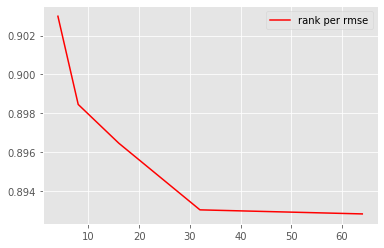

In [75]:
# 시각화 
plt.plot(ranks, rmse_test, label='rank per rmse', color='r')
plt.legend()
print( np.min( rmse_test ) )
# rank값 32에서 안정화가 되므로, rank값은 32를 추천(현 데이터에서)

In [76]:
seed

333

In [77]:
X_test

<9430x2623 sparse matrix of type '<class 'numpy.float64'>'
	with 18858 stored elements in Compressed Sparse Row format>

In [78]:
# 훈련, 검증에 한번도 관여하지 않은 데이터 X_test, y_test를 위에서 만든 rank=32에
# 대비하여 평가 
fm     = mcmc.FMRegression( n_iter=300, rank=32, random_state=seed )

In [79]:
y_pred = fm.fit_predict( X_train, y_train, X_test )

In [80]:
np.sqrt( mean_squared_error( y_pred, y_test ) )

0.921496840062798

- 상위에서 획득한 0.89에 비해서는 0.92는 높은값이다
- 하이퍼파라미터는 고정하고 나서, 최적화를 생각해본다면, 데이터쪽을 봐야하는데,
- 편차가 크다고 느낄수 있는 파트가 y_train (1 ~ 5)를 0 ~ 1사이로 정규화 하여 성능향상을 확인 -> 평점 자체가 들쑥 날쑥하기 때문에, 0 ~ 1 사이 구간으로 데이터를 표현

In [81]:
type( y_train ),y_train.shape, y_train.ndim, len(y_train.shape)

(numpy.ndarray, (81513,), 1, 1)

In [82]:
# 평점 정규화를 위해서 standardScaler를 사용하겠다
# 데이터는 2차원 배열이 되야 한다
# y_train => 2차 배열로 재구성
y_train.reshape( -1, 1)

array([[4.],
       [5.],
       [2.],
       ...,
       [4.],
       [1.],
       [1.]])

In [83]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [84]:
scaler       = StandardScaler()
y_train_norm = scaler.fit_transform( y_train.reshape( -1, 1) ).ravel()
y_train_norm.shape

(81513,)

In [85]:
y_train_norm.shape

(81513,)

In [86]:
np.max(y_train_norm), np.min(y_train_norm)

(1.3123995664191799, -2.2373992923481385)

In [87]:
# 다시 테스트
fm     = mcmc.FMRegression( n_iter=300, rank=32, random_state=seed )
y_pred = fm.fit_predict( X_train, y_train_norm, X_test )
np.sqrt( mean_squared_error( y_pred, scaler.transform(y_test.reshape( -1, 1)) ) )

0.8167593559001377

In [88]:
# 평점 정규화전 0.921496840062798
# 평점 정규화후 0.8167593559001377

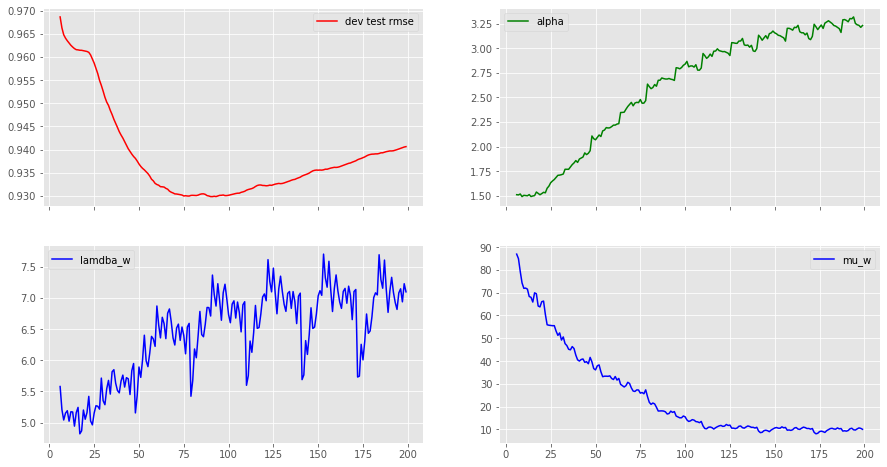

In [89]:
# 하이퍼파라미터 고정, 평점 정규화후 수렴과정 확인
n_iter    = 200
step_size = 1
seed      = 123
rank      = 32
# 알고리즘 생성 
fm        = mcmc.FMRegression( n_iter=0, rank=rank, random_state=seed )
# 훈련및 예측
fm.fit_predict( X_train, y_train_norm, X_test )

#손실함수 
rmse_test = list()
#하이퍼파람
hyper_param=np.zeros( (n_iter-1, 2*rank + 3), dtype=np.float64 ) 

for nr, i in enumerate( range(1, n_iter) ): # 1~199
    fm.random_state = i * seed
    # 데이터가 작아서 조금식 범위를 이동해가면서 훈련및 예측 : step_size
    y_pred = fm.fit_predict( X_train, y_train_norm, X_test, n_more_iter=step_size )
    # 예측값을 되돌려서 y_test 원래값(1~5)에 들어오게 복원
    rmse_test.append( np.sqrt( mean_squared_error( 
                                scaler.inverse_transform(y_pred), y_test ) ) )
    hyper_param[ nr, :] = fm.hyper_param_
    
# 시각화
# step_size가 1이여서 위에서는 표현을 않했을뿐, 실제로는 곱해줘야 한다
x       = np.arange( 1, n_iter ) * step_size
skip_idx= 5 # burn_in = 5 이런 변수명으로 주로 쓴다

fig, axes =  plt.subplots( nrows=2, ncols=2, sharex=True, figsize=(15,8) )

axes[0, 0].plot( x[skip_idx:], rmse_test[skip_idx:], label='dev test rmse', color='r' )
axes[0, 0].legend()

axes[0, 1].plot( x[skip_idx:], hyper_param[skip_idx:, 0], label='alpha', color='g' )
axes[0, 1].legend()

axes[1, 0].plot( x[skip_idx:], hyper_param[skip_idx:, 1], label='lamdba_w', color='b' )
axes[1, 0].legend()

axes[1, 1].plot( x[skip_idx:], hyper_param[skip_idx:, 3], label='mu_w', color='b' )
axes[1, 1].legend()

In [90]:
# 최저값
print( np.min(rmse_test) )

0.9298262388322737


In [91]:
# y값이 최저값일때의 x값
x[np.argmin(rmse_test)]

91

In [92]:
n_iter    = 200
x = np.arange( 1, n_iter ) * 3
x, x.shape

(array([  3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,  39,
         42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,  78,
         81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114, 117,
        120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156,
        159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195,
        198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234,
        237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273,
        276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312,
        315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351,
        354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390,
        393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429,
        432, 435, 438, 441, 444, 447, 450, 453, 456, 459, 462, 465, 468,
        471, 474, 477, 480, 483, 486, 489, 492, 495, 498, 501, 504, 507,
        510, 513, 516, 519, 522, 525, 528, 531, 534

#### 정보 추가

- 현재는 사용자ID, 영화id만 존재 
- 개봉연도, 사용자 나이, 성별, 평가연도등 추가
- 이런 특성의 조합(어떤 특성을 사용하는가? 어떤 순서로 사용하는가?)

In [93]:
movie_lens.columns
movie_lens.dtypes

mid                            int64
title                         object
release_date                  object
video_release_date           float64
imdb_url                      object
uid                            int64
rating                         int64
unix_timestamp                 int64
date                  datetime64[ns]
age                            int64
m                             object
job                           object
zip_code                      object
dtype: object

In [94]:
# 'date' 컬럼값에서 년도 1998만 뽑아서 문자열로 다시 넣어라 'date1'으로 추가
# 데이터 타입 자체가 datetime64즉 timestamp여서 시간의 성분을 직접 추출할수 있다
movie_lens['date'][0].year

1998

In [95]:
a= movie_lens['date'].apply( lambda x: str(x.year) )[0]
a, type(a)

('1998', str)

In [96]:
movie_lens['date1'] = movie_lens['date'].apply( lambda x: str(x.year) )

In [97]:
# 데이터 추가를 위해 조정
movie_lens['uid'] = movie_lens['uid'].astype(str)
movie_lens['mid'] = movie_lens['mid'].astype(str)
movie_lens.dtypes

mid                           object
title                         object
release_date                  object
video_release_date           float64
imdb_url                      object
uid                           object
rating                         int64
unix_timestamp                 int64
date                  datetime64[ns]
age                            int64
m                             object
job                           object
zip_code                      object
date1                         object
dtype: object

In [98]:
movie_lens[:1]

,mid,title,release_date,video_release_date,imdb_url,uid,rating,unix_timestamp,date,age,m,job,zip_code,date1
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076,1998


In [99]:
# 컬럼 조합 후보리스트
candidate_columns = [
    ['uid','mid','age','m','date1','rating'], # 6
    ['uid','mid','m','date1','rating'], # 5
    ['uid','mid','age','m','rating'], # 5
    ['uid','mid','rating'], # 3
]
# 어떤 조합, 순서(다 구성한것은 아니다)이 성능이 좋게 나오는지 확인

In [100]:
movie_lens[ candidate_columns[1] ].head(2)

,uid,mid,m,date1,rating
0,308,1,M,1998,4
1,308,4,M,1998,5


- 아래코드는 테스트 코드 (start) 

In [101]:
movie_lens[ candidate_columns[1] ].shape

(100000, 5)

In [102]:
movie_lens.dropna().shape

(0, 14)

In [103]:
# 누락값 제거 
movie_lens[ candidate_columns[1] ].dropna().shape

(100000, 5)

In [106]:
filtedNaN_lens = movie_lens[ candidate_columns[1] ].dropna() 
filtedNaN_lens.drop('rating', axis=1)[:2]

,uid,mid,m,date1
0,308,1,M,1998
1,308,4,M,1998


In [107]:
filtedNaN_lens.drop('rating', axis=1).T

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
uid,308,308,308,308,308,308,308,308,308,308,...,729,729,729,729,729,729,729,729,729,729
mid,1,4,5,7,8,9,11,12,15,17,...,354,362,683,689,690,748,751,879,894,901
m,M,M,M,M,M,M,M,M,M,M,...,M,M,M,M,M,M,M,M,M,M
date1,1998,1998,1998,1998,1998,1998,1998,1998,1998,1998,...,1998,1998,1998,1998,1998,1998,1998,1998,1998,1998


In [108]:
filtedNaN_lens.drop('rating', axis=1).T.to_dict()

{0: {'uid': '308', 'mid': '1', 'm': 'M', 'date1': '1998'},
 1: {'uid': '308', 'mid': '4', 'm': 'M', 'date1': '1998'},
 2: {'uid': '308', 'mid': '5', 'm': 'M', 'date1': '1998'},
 3: {'uid': '308', 'mid': '7', 'm': 'M', 'date1': '1998'},
 4: {'uid': '308', 'mid': '8', 'm': 'M', 'date1': '1998'},
 5: {'uid': '308', 'mid': '9', 'm': 'M', 'date1': '1998'},
 6: {'uid': '308', 'mid': '11', 'm': 'M', 'date1': '1998'},
 7: {'uid': '308', 'mid': '12', 'm': 'M', 'date1': '1998'},
 8: {'uid': '308', 'mid': '15', 'm': 'M', 'date1': '1998'},
 9: {'uid': '308', 'mid': '17', 'm': 'M', 'date1': '1998'},
 10: {'uid': '308', 'mid': '19', 'm': 'M', 'date1': '1998'},
 11: {'uid': '308', 'mid': '21', 'm': 'M', 'date1': '1998'},
 12: {'uid': '308', 'mid': '22', 'm': 'M', 'date1': '1998'},
 13: {'uid': '308', 'mid': '23', 'm': 'M', 'date1': '1998'},
 14: {'uid': '308', 'mid': '24', 'm': 'M', 'date1': '1998'},
 15: {'uid': '308', 'mid': '25', 'm': 'M', 'date1': '1998'},
 16: {'uid': '308', 'mid': '28', 'm': 'M

In [110]:
'''
[ {'uid': '308', 'mid': '1'}, {'uid': '308', 'mid': '31'}, ... ]
'''
list( filtedNaN_lens[:2].drop('rating', axis=1).T.to_dict().values() )

[{'uid': '308', 'mid': '1', 'm': 'M', 'date1': '1998'},
 {'uid': '308', 'mid': '4', 'm': 'M', 'date1': '1998'}]

- 위코드는 테스트 코드 (end)

In [127]:
# 실험 임계값
rmse_test = list()
n_iter    = 500
seed      = 123
rank      = 8
split_seed= 42

# 조합별 반복 훈련 및 검증
for column in candidate_columns:
    # 누락값 제거
    filtedNaN_lens = movie_lens[ column ].dropna()   
    
    # 백터화처리(평점 부분 고려)
    v         = DictVectorizer()  
    # 위에서 살펴 봤던 더미 데이터와 동일 구조
    tmp       = list( filtedNaN_lens.drop('rating', axis=1).T.to_dict().values() )
    #print( len(tmp) )
    X_feature =  v.fit_transform( tmp )
    #print( X_feature.shape )
    # 정답
    y_featue  = filtedNaN_lens['rating'].tolist()
    #print( len(y_featue) )
    
    # 데이터 분류(훈련, 테스트)  
    X_mc_train, X_mc_test, y_mc_train, y_mc_test = train_test_split( X_feature, 
                                y_featue, test_size=0.1, random_state=split_seed )
    #print( type(X_mc_train) )
    #print( '-'*10)
    #print( type(X_mc_test)  )
    
    
    #print( X_mc_train.shape )
    #print( X_mc_test.shape )
    
    
    # 평점 정규화
    scaler = StandardScaler()
    # 리스트 y_mc_train을 입력형태에 맞게 2차 배열로 변환
    # ravel() 다차원 배열을 1차원 배열로 평평하게 펴준다
    y_mc_train_norm = scaler.fit_transform( np.array(y_mc_train).reshape(-1,1) ).ravel()
    #print( y_mc_train_norm.shape )
    
    
    # 알고리즘 생성
    fm     = mcmc.FMRegression( n_iter=n_iter, rank=rank, random_state=seed )
    # 훈련 및예측
    print( X_mc_train.shape, y_mc_train_norm.shape, X_mc_test.shape )
    y_pred = fm.fit_predict( X_mc_train, y_mc_train_norm, X_mc_test )
    #break
    
    # RMSE값 계산
    tmp2   = scaler.inverse_transform( y_pred.reshape(-1, 1) )
    rmse_test.append( np.sqrt( mean_squared_error( tmp2, y_mc_test) ) )

# 시각화 (성능 조합 대비 RMSE 비교)
print( rmse_test )

(90000, 2630) (90000,) (10000, 2630)
(90000, 2629) (90000,) (10000, 2629)
(90000, 2628) (90000,) (10000, 2628)
(90000, 2625) (90000,) (10000, 2625)
[0.8932954994137019, 0.8856376107037375, 0.8925456956173278, 0.887744557428427]


(0.88, 0.9)

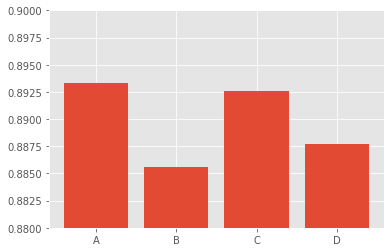

In [130]:
# 시각화
x_incre = np.arange( len(candidate_columns) )
bar     = plt.bar( x_incre, height=rmse_test )
plt.xticks( x_incre, list('ABCD') )
plt.ylim( 0.88, 0.90 )

In [131]:
# 평가
# 어떤 특성을 추가하면 혹은 배치하면 성능을 높일수 있는지 검증이 가능
# 이렇게 사용자 정보(uid)와 영화 정보(mid)이외의 정보를 활용하여
# 추천같은 상황을 인지할수 있는 방식 => 인지 추천이라고 한다

['uid', 'mid', 'm', 'date1', 'rating']

In [ ]:
# 6. 시스템통합 (서비스에 반영, OTT, 쇼핑몰 등등 대상)

In [ ]:
y_train